In [32]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from time import time

class MeanShift:
    
    def __init__(self, spacial_threshold=2.0, range_threshold=10.0, max_iter=20, kernel='guassian',min_region_size=5):
        self.__spacial_threshold = spacial_threshold
        self.__range_threshold = range_threshold
        self.__max_iter = max_iter
        self.__min_region_size = min_region_size
        if kernel == 'gaussian':
            self.__kernel_function = self.__gaussian_kernel_function
        else:
            self.__kernel_function = self.__epanechnikov_kernel_function
        
    def __gaussian_kernel_function(self, x):
        return math.exp(-0.5*np.sum(x**2))
    
    def __epanechnikov_kernel_function(self, x):
        return 0.75*(1-np.sum(x**2))
    
    def __derivative(self, x):
        if x > 1:
            return 0
        else:
            return 1
    
    def __euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a-b)**2))
    
    def __seek_centroid(self, image_points, bandwidth):
        first_point = image_points[0]
        last_centroid = first_point
        iteration = 0
        while iteration < self.__max_iter:
            iteration += 1
            centroid = self.__meanshift(image_points, last_centroid, bandwidth)
            distance = self.__euclidean_distance(last_centroid, centroid)
            if distance < self.__range_threshold or np.all(centroid == last_centroid):
                break
            last_centroid = centroid
        return centroid
    
    def __meanshift(self, image_points, centroid, color_bandwidth):
        shift = np.zeros_like(centroid)
        weight_sum = 0.0
        for point in image_points:
            weight = self.__derivative(self.__kernel_function((centroid - point) / color_bandwidth))
            shift = shift + (point * weight)
            weight_sum += weight
        if weight_sum == 0.0:
            return centroid
        else:
            return (shift / weight_sum).astype('int')
    
    def __getImageVector(self,image):
        pixel_values = image.reshape(-1, image.shape[-1])
        rows, columns, channels = image.shape
        pixel_coords = np.zeros((rows, columns, 2))
        for i in range(0,rows):
            for j in range(0,columns):
                pixel_coords[i,j] = np.array([i,j])
        pixel_coords = pixel_coords.reshape(pixel_coords.shape[0]*pixel_coords.shape[1], pixel_coords.shape[-1])
        image_vector = np.hstack([pixel_coords, pixel_values])
        return image_vector
    
    def __filter(self, image):
        self.__image_vector = self.__getImageVector(image)
        self.__auxillary_grid = np.arange(0,len(self.__image_vector)).reshape(image.shape[0], image.shape[1])
        pixel_ids = range(0,len(self.__image_vector))
        pixels_to_process = dict.fromkeys(pixel_ids)
        
        regions = []
        
        while len(pixels_to_process) > 0:
            random_pixel_tuple = pixels_to_process.popitem()
            #print "Random Pixel: ",random_pixel_tuple
            #Fill in the code below - locally; do "popitem()" for each pixel you add to window
            window = self.__getPixelWindow(random_pixel_tuple[0], pixels_to_process)
            window_values = self.__getWindowValues(window)
            window_centroid_value = self.__seek_centroid(window_values,self.__range_threshold)
            for pixel in window:
                if window_centroid_value[0] < 0:
                    window_centroid_value[0] += 255
                if window_centroid_value[1] < 0:
                    window_centroid_value[1] += 255
                if window_centroid_value[2] < 0:
                    window_centroid_value[2] += 255
                
                if window_centroid_value[0] > 255:
                    window_centroid_value[0] = 255
                if window_centroid_value[1] > 255:
                    window_centroid_value[1] = 255
                if window_centroid_value[2] > 255:
                    window_centroid_value[2] = 255
                
                pixel[2] = window_centroid_value[0]
                pixel[3] = window_centroid_value[1]
                pixel[4] = window_centroid_value[2]
            regions.append(window)
        return regions
    
    def __getPixelWindow(self, random_pixel_id, pixels_to_process):
        random_pixel = self.__image_vector[random_pixel_id]
        #print "Random Pixel Value: ", random_pixel
        random_pixel_x = random_pixel[0]
        random_pixel_y = random_pixel[1]
        left_limit = int(random_pixel_x - self.__spacial_threshold)
        right_limit = int(random_pixel_x + self.__spacial_threshold)
        top_limit = int(random_pixel_y - self.__spacial_threshold)
        bottom_limit = int(random_pixel_y + self.__spacial_threshold)
        if left_limit < 0:
            left_limit = 0
        if right_limit > self.__auxillary_grid.shape[0]:
            right_limit = self.__auxillary_grid.shape[0]
        if top_limit < 0:
            top_limit = 0
        if bottom_limit > self.__auxillary_grid.shape[1]:
            bottom_limit = self.__auxillary_grid.shape[1]
        frame = self.__auxillary_grid[left_limit:right_limit, top_limit:bottom_limit]
        frame = frame.ravel()
        nframe = []
        for pixel_id in frame:
            if pixel_id == random_pixel_id or pixel_id not in pixels_to_process:
                continue
            nframe.append(pixel_id)
        frame = np.array(nframe)
        
        if frame.size ==0:
            return np.array([random_pixel])
        #print "Frame Ravel: ",frame
        frame_pixel_values = self.__image_vector[frame][:,2:]
        #print "Frame Values: ",frame_pixel_values
        frame_pixel_values -= random_pixel[2:]
        #print "After Subtraction: ", frame_pixel_values
        frame_pixel_values **=2
        frame_pixel_distances = np.sqrt(np.sum(frame_pixel_values, axis=1))
        
        frame = frame[frame_pixel_distances <= self.__range_threshold]
        #print "Distances: ", frame_pixel_distances
        for pixel_id in frame:
            pixels_to_process.pop(pixel_id)
        if frame.size ==0:
            return np.array([random_pixel])
        return np.vstack([self.__image_vector[frame], random_pixel])
    
    def __getWindowValues(self, window):
        return window[:,2:]
    
    def __regionsToImage(self,image,regions):
        result = np.empty_like(image)
        for region in regions:
            for pixel in region:
                result[int(pixel[0]),int(pixel[1])] = pixel[2:]
        return result
    
    def __mergeRegions(self, image, regions):
        spatial_centroids = []
        range_centroids = []
        for region in regions:
            c = self.__seek_centroid(region[:,:2],self.__spacial_threshold)
            spatial_centroids.append(np.rint(c).astype(int))
            range_centroids.append(region[0][2:])
        #print "Centroids Computed = ",len(spatial_centroids)
        spatial_centroids = np.array(spatial_centroids)
        range_centroids = np.array(range_centroids)
        lookup_matrix = np.zeros((image.shape[0], image.shape[1])).astype(int)
        labels = {}
        for i,centroid in enumerate(spatial_centroids):
            lookup_matrix[centroid[0],centroid[1]] = i
            labels[i] = i
        visited = {}
        #print lookup_matrix[0,0]
        indexes = range(len(spatial_centroids))
        random.seed(0)
        random.shuffle(indexes)
        for i in indexes:
            visited[i] = True
            #print visited
            window = self.__getCentroidWindow(lookup_matrix, spatial_centroids[i], visited, spatial_centroids, range_centroids)
            
            for r in window:
                labels[r] = labels[i]
        region_groups = {}
        for k,v in labels.items():
            if v not in region_groups:
                region_groups[v] = [k]
            else:
                region_groups[v].append(k)
        final_regions = []
        
        for k,group in region_groups.items():
            merged_group = None
            for region in group:
                if not np.all(merged_group):
                    merged_group = regions[region]
                else:
                    #print "Existing: ",merged_group.shape
                    #print "New: ",regions[region].shape
                    merged_group = np.vstack([merged_group,regions[region]])
            final_regions.append(merged_group)
        for region in final_regions:
            new_centroid = self.__seek_centroid(region[:,2:], self.__range_threshold)
            region[:,2:] = new_centroid
        #print "Final Regions: ",len(final_regions)
        temp = []
        for region in final_regions:
            if len(region) < self.__min_region_size and len(temp) > 1:
                region[:,2:] = temp[-1][0][2:]
                temp[-1] = np.vstack([temp[-1], region])
            else:
                temp.append(region)
        final_regions = temp
        return final_regions
        
    
    def __getCentroidWindow(self, lookup_matrix, centroid, visited, spatial_centroids, range_centroids):
        left_limit = centroid[0] - self.__spacial_threshold
        right_limit = centroid[0] + self.__spacial_threshold +1
        top_limit = centroid[1] - self.__spacial_threshold
        bottom_limit = centroid[1] + self.__spacial_threshold +1
        if left_limit < 0:
            left_limit = 0
        if right_limit > self.__auxillary_grid.shape[0]:
            right_limit = self.__auxillary_grid.shape[0]
        if top_limit < 0:
            top_limit = 0
        if bottom_limit > self.__auxillary_grid.shape[1]:
            bottom_limit = self.__auxillary_grid.shape[1]
        result = []
        centroid_region = lookup_matrix[centroid[0],centroid[1]]
        for i in range(left_limit, right_limit):
            for j in range(top_limit, bottom_limit):
                if lookup_matrix[i,j] != 0 and lookup_matrix[i,j] not in visited:
                    #print lookup_matrix[i,j]
                    if self.__euclidean_distance(range_centroids[centroid_region], range_centroids[lookup_matrix[i,j]]) < self.__range_threshold:
                        result.append(lookup_matrix[i,j])
        return result
    
    def __overlayBorders(self, image):
        edges = cv2.Canny(image, 20, 240)
        return cv2.addWeighted(image, 1.0, np.dstack((edges,edges,edges)), 1.0,0)
    
    def segment(self, image):
        print "Beginning segmentation process.."
        tf = time()
        regions = self.__filter(image)
        print "Completed filtering in ",round(time()-tf,2)," seconds"
        tm = time()
        m_regions = self.__mergeRegions(image, regions)
        print "Completed region merging in ",round(time()-tm,2)," seconds"
        result = self.__regionsToImage(image,m_regions)
        return result, self.__overlayBorders(result)


Beginning segmentation process..
Completed filtering in  4.34  seconds
Completed region merging in  5.8  seconds


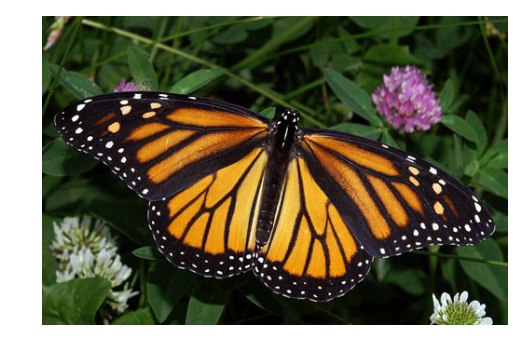

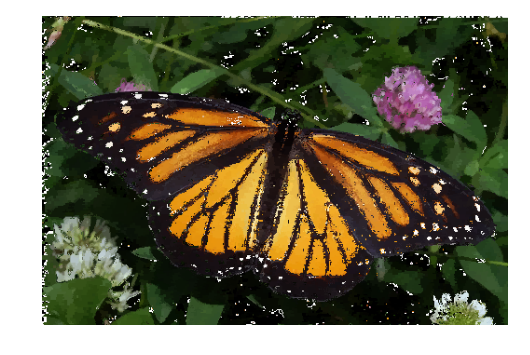

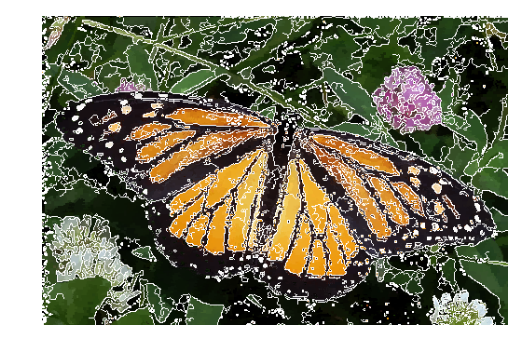

In [33]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt

im = cv2.cvtColor(cv2.imread('butterfly.jpg'), cv2.COLOR_BGR2RGB)

ms_object = MeanShift(3,20,kernel="epanechnikov")
result, result_with_borders = ms_object.segment(im)

def display_image(image):
    #plt.set_cmap('gray')
    plt.axis("off")
    plt.imshow(image)
    plt.show()

display_image(im)
display_image(result)
display_image(result_with_borders)